In [24]:
import pandas as pd
import numpy as np
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import MinMaxScaler
from sklearn.cluster import KMeans

In [2]:
vel01 = pd.read_csv('data/VDS_지점통행속도_5분_1일_20240601.csv',encoding='cp949')
vel01 = vel01.iloc[:,[2,1,5]]
vel01 = vel01.rename(columns={'집계시분':'time','평균속도':'avgVel'})
vel01 = vel01.sort_values(by=['VDS_ID','time'], ignore_index=True)
vel01.head()

,VDS_ID,time,avgVel
0,0010VDE00100,00:00,83.26
1,0010VDE00100,00:05,84.60
2,0010VDE00100,00:10,88.46
3,0010VDE00100,00:15,86.53
4,0010VDE00100,00:20,93.66


In [16]:
# slice
data = []
vds = vel01['VDS_ID'].unique()
for i in range(len(vds)):
    data.append(vel01['avgVel'].values[288*i:288*(i+1)])
data = np.array(data)
print(np.shape(data))
bMask = [np.any(elem!=-1.0) for elem in data]
data = data[bMask]
data

(7914, 288)


array([[ 83.26,  84.6 ,  88.46, ...,  87.58,  85.14,  85.15],
       [100.93,  98.47, 104.68, ...,  95.99,  98.77,  98.28],
       [ 92.78,  88.06,  97.13, ...,  89.19,  89.52,  92.4 ],
       ...,
       [101.85,  97.65,  97.2 , ..., 103.8 , 102.95, 105.75],
       [106.85, 102.3 , 101.45, ..., 109.3 , 113.  , 109.1 ],
       [115.4 , 110.45, 105.4 , ..., 109.7 , 110.78, 103.95]])

In [17]:
# replace outliers with NaN and fill it with the avg of its neighbors
for i in range(len(data)):
    Q1 = np.percentile(data[i], 25, method='midpoint')
    Q3 = np.percentile(data[i], 75, method='midpoint')
    lowerB = Q1-1.5*(Q3-Q1)
    upperB = Q1+1.5*(Q3-Q1)
    for j in range(288):
        if (data[i][j] < lowerB) | (data[i][j] > upperB):
            data[i][j] = np.nan

In [62]:
# convert the list 'data' to pd.Series to apply .fillna()
list_of_series = []
for i in range(len(data)):
    elem_series = pd.Series(data[i])
    elem_series = elem_series.ffill()
    elem_series = elem_series.bfill()
    list_of_series.append(elem_series.tolist())
data = np.array(list_of_series)

In [57]:
elem_series = pd.Series(data[1])
print(elem_series.isna().sum())
elem_series

34


0         NaN
1       98.47
2         NaN
3       98.71
4         NaN
        ...  
283    100.57
284       NaN
285     95.99
286     98.77
287     98.28
Length: 288, dtype: float64

In [61]:
elem_series = pd.Series(data[1])
elem_series = elem_series.ffill()
elem_series = elem_series.bfill()
print(elem_series.isna().sum())

0


In [63]:
# standardization
scaled_data = []
for i in range(np.shape(data)[0]):
    scaler = MinMaxScaler()
    scaled_data.append(scaler.fit_transform(data[i].reshape(-1,1)))
print(np.shape(scaled_data))
scaled_data = np.array(scaled_data)
scaled_data = scaled_data.reshape(7047,288)
print(np.shape(scaled_data))

(7047, 288, 1)
(7047, 288)


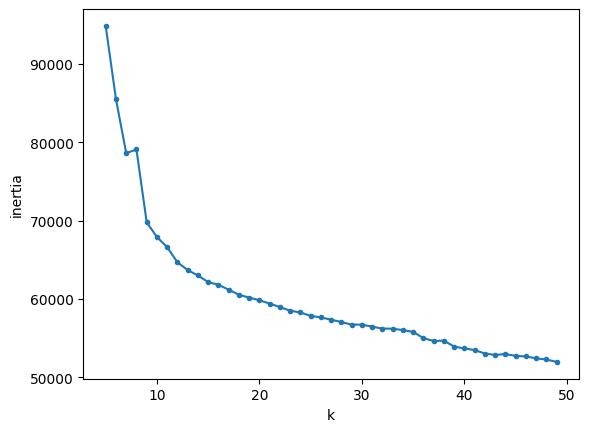

In [64]:
# find the best k for K-Means alg
inertia = []
for k in range(5,50):
    km = KMeans(n_clusters=k, random_state=42)
    km.fit(scaled_data)
    inertia.append(km.inertia_)

# find an elbow by plotting values of inertia
plt.plot(range(5,50),inertia,'.-')
plt.xlabel('k')
plt.ylabel('inertia')
plt.show()

In [66]:
def draw_pattern(arr):
    row = int(np.ceil(len(arr)/5))
    col = 5
    fig, axs = plt.subplots(row,col,sharex=True, sharey=True)
    plt.tight_layout()
    for i in range(row):
        for j in range(col):
            if i*col + j < len(arr):
                axs[i][j].plot(range(len(arr[col*i+j])), arr[col*i+j])
                axs[i][j].set_title(col*i+j)

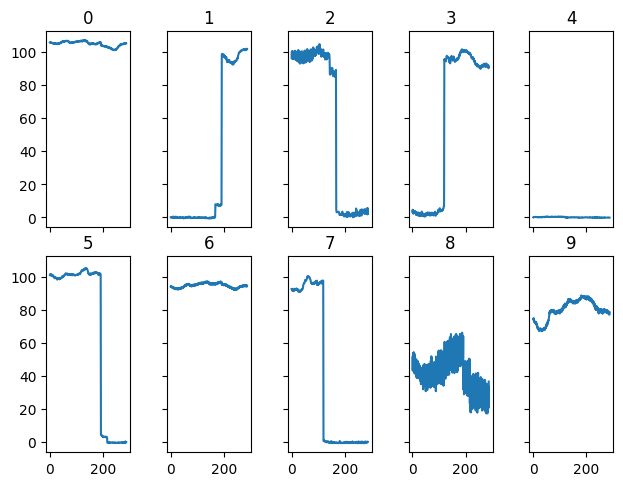

In [67]:
# k=10
km10 = KMeans(n_clusters=10, random_state=42)
km10.fit(data)
# draw cluster centers
draw_pattern(km10.cluster_centers_)

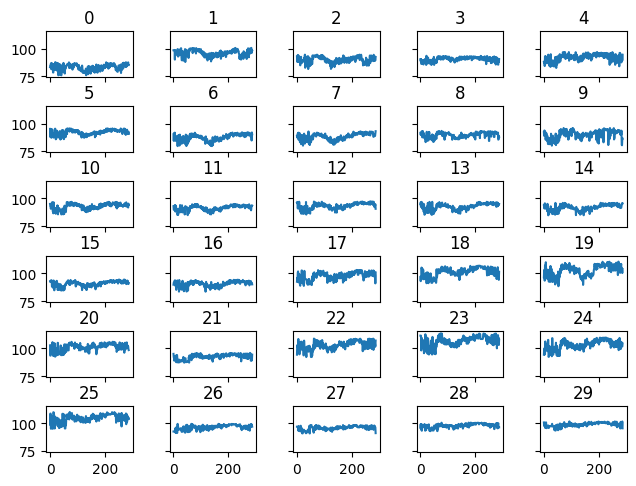

In [68]:
draw_pattern(data[:30])

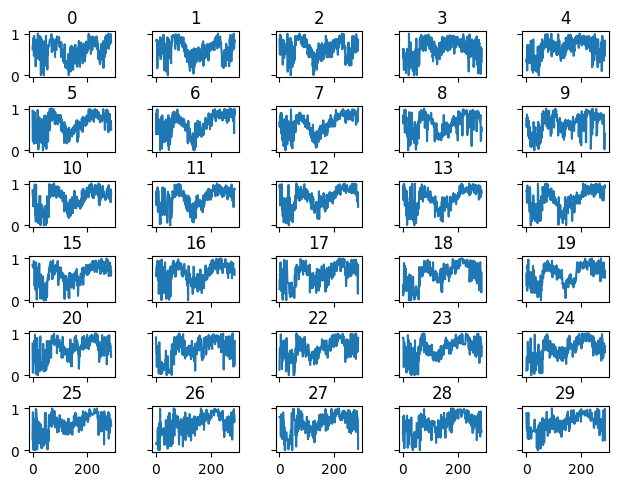

In [69]:
draw_pattern(scaled_data[:30])

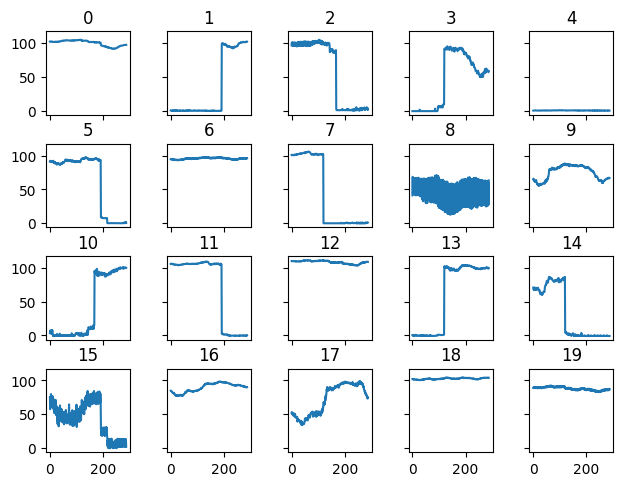

In [71]:
# k=20
km20 = KMeans(n_clusters=20, random_state=42)
km20.fit(data)
# draw cluster centers
draw_pattern(km20.cluster_centers_)

# look at 8. see what's wrong? -> p4_smoothing_spline
# try different percentiles

In [72]:
# slice
data = []
vds = vel01['VDS_ID'].unique()
for i in range(len(vds)):
    data.append(vel01['avgVel'].values[288*i:288*(i+1)])
data = np.array(data)
print(np.shape(data))
bMask = [np.any(elem!=-1.0) for elem in data]
data = data[bMask]
data

(7914, 288)


array([[ 83.26,  84.6 ,  88.46, ...,  87.58,  85.14,  85.15],
       [100.93,  98.47, 104.68, ...,  95.99,  98.77,  98.28],
       [ 92.78,  88.06,  97.13, ...,  89.19,  89.52,  92.4 ],
       ...,
       [101.85,  97.65,  97.2 , ..., 103.8 , 102.95, 105.75],
       [106.85, 102.3 , 101.45, ..., 109.3 , 113.  , 109.1 ],
       [115.4 , 110.45, 105.4 , ..., 109.7 , 110.78, 103.95]])

In [73]:
# replace outliers with NaN and fill it with the avg of its neighbors
for i in range(len(data)):
    q5 = np.percentile(data[i], 5, method='midpoint')
    q95 = np.percentile(data[i], 95, method='midpoint')
    for j in range(288):
        if (data[i][j] < q5) | (data[i][j] > q95):
            data[i][j] = np.nan

In [74]:
# convert the list 'data' to pd.Series to apply .fillna()
list_of_series = []
for i in range(len(data)):
    elem_series = pd.Series(data[i])
    elem_series = elem_series.ffill()
    elem_series = elem_series.bfill()
    list_of_series.append(elem_series.tolist())
data = np.array(list_of_series)

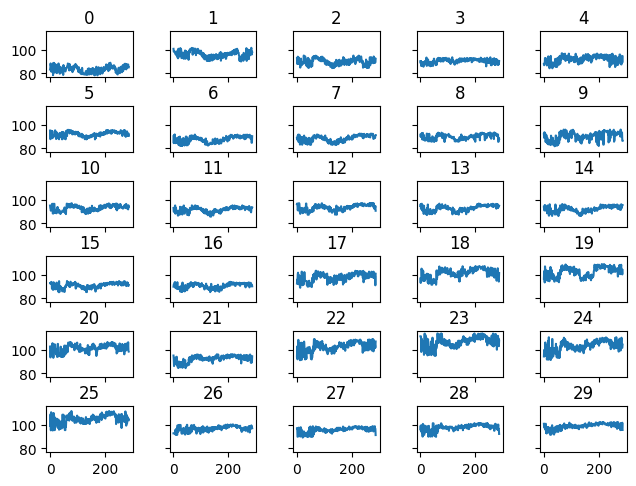

In [81]:
draw_pattern(data[:30])

(7914, 288)


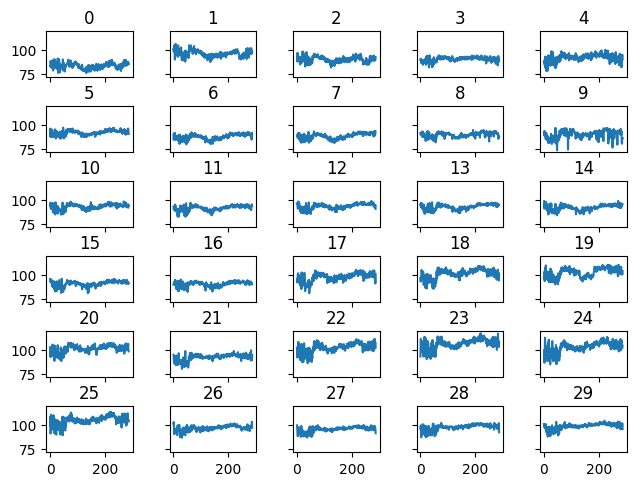

In [82]:
# slice
data = []
vds = vel01['VDS_ID'].unique()
for i in range(len(vds)):
    data.append(vel01['avgVel'].values[288*i:288*(i+1)])
data = np.array(data)
print(np.shape(data))
bMask = [np.any(elem!=-1.0) for elem in data]
data = data[bMask]

# replace outliers with NaN and fill it with the avg of its neighbors
for i in range(len(data)):
    q5 = np.percentile(data[i], 1, method='midpoint')
    q95 = np.percentile(data[i], 99, method='midpoint')
    for j in range(288):
        if (data[i][j] < q5) | (data[i][j] > q95):
            data[i][j] = np.nan

# convert the list 'data' to pd.Series to apply .fillna()
list_of_series = []
for i in range(len(data)):
    elem_series = pd.Series(data[i])
    elem_series = elem_series.ffill()
    elem_series = elem_series.bfill()
    list_of_series.append(elem_series.tolist())
data = np.array(list_of_series)

draw_pattern(data[:30])